In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
from d2l import tensorflow as d2l
from IPython import display
from matplotlib import pyplot as plt
import time

In [2]:
def use_svg_display():
    """使用svg格式在Jupyter中显示绘图

    Defined in :numref:`sec_calculus`"""
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    """设置matplotlib的图表大小

    Defined in :numref:`sec_calculus`"""
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """设置matplotlib的轴

    Defined in :numref:`sec_calculus`"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

def plot(X, Y=None, xlabel=None, ylabel=None, legend=None, xlim=None,
         ylim=None, xscale='linear', yscale='linear',
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(3.5, 2.5), axes=None):
    """绘制数据点

    Defined in :numref:`sec_calculus`"""
    if legend is None:
        legend = []

    set_figsize(figsize)
    axes = axes if axes else plt.gca()

    # 如果X有一个轴，输出True
    def has_one_axis(X):
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
                and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt)
        else:
            axes.plot(y, fmt)
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)

In [3]:
class Accumulator:
    """在n个变量上累加"""
    def __init__(self, n):
        """Defined in :numref:`sec_softmax_scratch`"""
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [4]:
class Timer:
    """记录多次运行时间"""
    def __init__(self):
        """Defined in :numref:`subsec_linear_model`"""
        self.times = []
        self.start()

    def start(self):
        """启动计时器"""
        self.tik = time.time()

    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)

    def sum(self):
        """返回时间总和"""
        return sum(self.times)

    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

In [5]:
timer = Timer()
A = tf.Variable(tf.zeros((256, 256)))
B = tf.Variable(tf.random.normal([256, 256], 0, 1))
C = tf.Variable(tf.random.normal([256, 256], 0, 1))

In [6]:
reshape = tf.reshape
ones = tf.ones
zeros = tf.zeros
meshgrid = tf.meshgrid
sin = tf.sin
sinh = tf.sinh
cos = tf.cos
cosh = tf.cosh
tanh = tf.tanh
linspace = tf.linspace
exp = tf.exp
normal = tf.random.normal
rand = tf.random.uniform
matmul = tf.matmul
reduce_sum = tf.reduce_sum
reduce_mean = tf.reduce_mean
argmax = tf.argmax
tensor = tf.constant
arange = tf.range
astype = tf.cast
int32 = tf.int32
float32 = tf.float32
transpose = tf.transpose
concat = tf.concat
stack = tf.stack
abs = tf.abs
eye = tf.eye
log = tf.math.log
size = lambda a: tf.size(a).numpy()
numpy = lambda x, *args, **kwargs: x.numpy(*args, **kwargs)

In [7]:
class Animator:
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        """Defined in :numref:`sec_softmax_scratch`"""
        # 增量地绘制多条线
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [8]:
def evaluate_loss(net, data_iter, loss):
    """评估给定数据集上模型的损失

    Defined in :numref:`sec_model_selection`"""
    metric = Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = reshape(y, out.shape)
        l = loss(out, y)
        metric.add(reduce_sum(l), size(l))
    return metric[0] / metric[1]

In [9]:
#@save
d2l.DATA_HUB['airfoil'] = (d2l.DATA_URL + 'airfoil_self_noise.dat',
                           '76e5be1548fd8222e5074cf0faae75edff8cf93f')

#@save
def get_data(batch_size=10, n=1500):
    data = np.genfromtxt(d2l.download('airfoil'),
                         dtype=np.float32, delimiter='\t')
    data = (data - data.mean(axis=0)) / data.std(axis=0)
    data_iter = d2l.load_array((data[:n, :-1], data[:n, -1]),
                               batch_size, is_train=True)
    return data_iter, data.shape[1]-1

# Customize a optimizer examples

In [10]:
def linreg(X, w, b):
    """线性回归模型

    Defined in :numref:`sec_linear_scratch`"""
    return tf.matmul(X, w) + b

def squared_loss(y_hat, y):
    """均方损失

    Defined in :numref:`sec_linear_scratch`"""
    return (y_hat - tf.reshape(y, y_hat.shape)) ** 2 / 2

In [11]:
#@save
def train_customize_optimizer(trainer_fn, states, hyperparams, data_iter,
               feature_dim, num_epochs=2):
    """Defined in :numref:`sec_minibatches`"""
    # 初始化模型
    w = tf.Variable(tf.random.normal(shape=(feature_dim, 1),
                                   mean=0, stddev=0.01),trainable=True)
    b = tf.Variable(tf.zeros(1), trainable=True)

    # 训练模型
    net, loss = lambda X: linreg(X, w, b), squared_loss
    animator = Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, Timer()

    for _ in range(num_epochs):
        for X, y in data_iter:
            with tf.GradientTape() as g:
                l = tf.math.reduce_mean(loss(net(X), y))

            dw, db = g.gradient(l, [w, b])
            trainer_fn([w, b], [dw, db], states, hyperparams)
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                p = n/X.shape[0]
                q = p/tf.data.experimental.cardinality(data_iter).numpy()
                r = (evaluate_loss(net, data_iter, loss),)
                animator.add(q, r)
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')
    return timer.cumsum(), animator.Y[0]

loss: 0.243, 0.078 sec/epoch


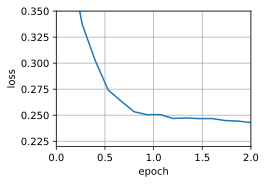

In [12]:
def sgd(params, grads, states, hyperparams):
    for param, grad in zip(params, grads):
        param.assign_sub(hyperparams['lr']*grad)
        
data_iter, feature_dim = get_data(batch_size=10)
train_customize_optimizer(sgd, None, {'lr': 0.02}, data_iter, feature_dim);

loss: 0.244, 0.063 sec/epoch


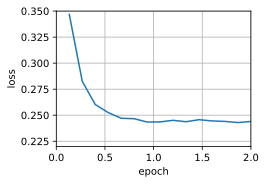

In [13]:
def init_momentum_states(features_dim):
    v_w = tf.Variable(tf.zeros((features_dim, 1)))
    v_b = tf.Variable(tf.zeros(1))
    return (v_w, v_b)

def sgd_momentum(params, grads, states, hyperparams):
    for p, v, g in zip(params, states, grads):
            v[:].assign(hyperparams['momentum'] * v + g)
            p[:].assign(p - hyperparams['lr'] * v)
data_iter, feature_dim = get_data(batch_size=10)
train_customize_optimizer(sgd_momentum, init_momentum_states(feature_dim),
                   {'lr': 0.02, 'momentum': 0.5}, data_iter,feature_dim);

loss: 0.242, 0.066 sec/epoch


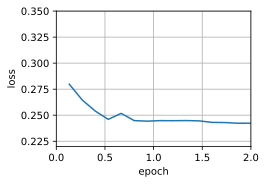

In [14]:
def init_adagrad_states(feature_dim):
    s_w = tf.Variable(tf.zeros((feature_dim, 1)))
    s_b = tf.Variable(tf.zeros(1))
    return (s_w, s_b)

def adagrad(params, grads, states, hyperparams):
    eps = 1e-6
    for p, s, g in zip(params, states, grads):
        s[:].assign(s + tf.math.square(g))
        p[:].assign(p - hyperparams['lr'] * g / tf.math.sqrt(s + eps))

data_iter, feature_dim = get_data(batch_size=10)
train_customize_optimizer(adagrad, init_adagrad_states(feature_dim),
               {'lr': 0.1}, data_iter, feature_dim);

loss: 0.243, 0.069 sec/epoch


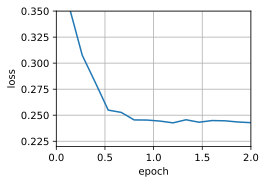

In [15]:
def init_rmsprop_states(feature_dim):
    s_w = tf.Variable(tf.zeros((feature_dim, 1)))
    s_b = tf.Variable(tf.zeros(1))
    return (s_w, s_b)

def rmsprop(params, grads, states, hyperparams):
    gamma, eps = hyperparams['gamma'], 1e-6
    for p, s, g in zip(params, states, grads):
        s[:].assign(gamma * s + (1 - gamma) * tf.math.square(g))
        p[:].assign(p - hyperparams['lr'] * g / tf.math.sqrt(s + eps))
        
data_iter, feature_dim = get_data(batch_size=10)
train_customize_optimizer(rmsprop, init_rmsprop_states(feature_dim),
               {'lr': 0.01, 'gamma': 0.9}, data_iter, feature_dim);

loss: 0.245, 0.088 sec/epoch


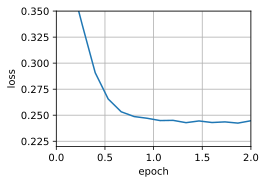

In [16]:
def init_adadelta_states(feature_dim):
    s_w = tf.Variable(tf.zeros((feature_dim, 1)))
    s_b = tf.Variable(tf.zeros(1))
    delta_w = tf.Variable(tf.zeros((feature_dim, 1)))
    delta_b = tf.Variable(tf.zeros(1))
    return ((s_w, delta_w), (s_b, delta_b))

def adadelta(params, grads, states, hyperparams):
    rho, eps = hyperparams['rho'], 1e-5
    for p, (s, delta), grad in zip(params, states, grads):
        s[:].assign(rho * s + (1 - rho) * tf.math.square(grad))
        g = (tf.math.sqrt(delta + eps) / tf.math.sqrt(s + eps)) * grad
        p[:].assign(p - g)
        delta[:].assign(rho * delta + (1 - rho) * g * g)
        
data_iter, feature_dim = get_data(batch_size=10)
train_customize_optimizer(adadelta, init_adadelta_states(feature_dim),
               {'rho': 0.9}, data_iter, feature_dim);

In [17]:
def init_adam_states(feature_dim):
    v_w = tf.Variable(tf.zeros((feature_dim, 1)))
    v_b = tf.Variable(tf.zeros(1))
    s_w = tf.Variable(tf.zeros((feature_dim, 1)))
    s_b = tf.Variable(tf.zeros(1))
    return ((v_w, s_w), (v_b, s_b))

In [18]:
def adam(params, grads, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-6
    for p, (v, s), grad in zip(params, states, grads):
        v[:].assign(beta1 * v  + (1 - beta1) * grad)
        s[:].assign(beta2 * s + (1 - beta2) * tf.math.square(grad))
        v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
        s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
        p[:].assign(p - hyperparams['lr'] * v_bias_corr
                    / tf.math.sqrt(s_bias_corr) + eps)

loss: 0.242, 0.089 sec/epoch


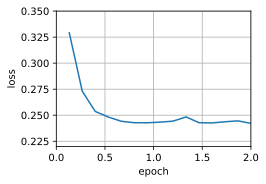

In [19]:
data_iter, feature_dim = get_data(batch_size=10)
train_customize_optimizer(adam, init_adam_states(feature_dim),
                          {'lr': 0.01, 't': 1}, data_iter, feature_dim);

## Yogi

Adam算法也存在一些问题：
即使在凸环境下，当$\mathbf{s}_t$的第二力矩估计值爆炸时，它可能无法收敛。
 :cite:`Zaheer.Reddi.Sachan.ea.2018`为$\mathbf{s}_t$提出了的改进更新和参数初始化。
论文中建议我们重写Adam算法更新如下：

$$\mathbf{s}_t \leftarrow \mathbf{s}_{t-1} + (1 - \beta_2) \left(\mathbf{g}_t^2 - \mathbf{s}_{t-1}\right).$$

每当$\mathbf{g}_t^2$具有高变量或更新稀疏时，$\mathbf{s}_t$可能会太快地“忘记”过去的值。
一个有效的解决方法是将$\mathbf{g}_t^2 - \mathbf{s}_{t-1}$替换为$\mathbf{g}_t^2 \odot \mathop{\mathrm{sgn}}(\mathbf{g}_t^2 - \mathbf{s}_{t-1})$。
这就是Yogi更新，现在更新的规模不再取决于偏差的量。

$$\mathbf{s}_t \leftarrow \mathbf{s}_{t-1} + (1 - \beta_2) \mathbf{g}_t^2 \odot \mathop{\mathrm{sgn}}(\mathbf{g}_t^2 - \mathbf{s}_{t-1}).$$

论文中，作者还进一步建议用更大的初始批量来初始化动量，而不仅仅是初始的逐点估计。

loss: 0.244, 0.100 sec/epoch


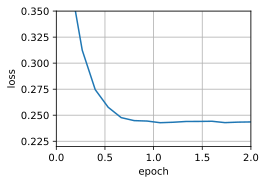

In [20]:
def yogi(params, grads, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-6
    for p, (v, s), grad in zip(params, states, grads):
        v[:].assign(beta1 * v  + (1 - beta1) * grad)
        s[:].assign(s + (1 - beta2) * tf.math.sign(
                   tf.math.square(grad) - s) * tf.math.square(grad))
        v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
        s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
        p[:].assign(p - hyperparams['lr'] * v_bias_corr
                    / tf.math.sqrt(s_bias_corr) + eps)
    hyperparams['t'] += 1

data_iter, feature_dim = get_data(batch_size=10)
train_customize_optimizer(yogi, init_adam_states(feature_dim),
               {'lr': 0.01, 't': 1}, data_iter, feature_dim);